## Trabalho Prático de Introdução ao Processamento Digital de Imagens

In [141]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import pennylane as qml
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import concurrent.futures

### RGB-HSB-RGB conversion

In [2]:
def rgb_to_hsb(pixel, mods=None):
    R, G, B = pixel
    pixel  =  R / 255, G / 255, B / 255
    R, G, B = pixel

    MAX = max(pixel)
    MIN = min(pixel)  
    
    # Hue value
    H = None
    S = None
    if(MAX == MIN):
        H = 0
    elif((MAX == R)):
        if(G >= B):
            H = 60 * ((G - B)/(MAX - MIN))
        else:
            H = (60 * ((G - B)/(MAX - MIN))) + 360
    
    elif(MAX == G):
        H = (60 * ((B - R)/(MAX - MIN))) + 120
    
    elif(MAX == B):
        H = (60 * ((R - G)/(MAX - MIN))) + 240

    # Saturation
    if(MAX == 0):
        S = 0
    else:
        S = 1 - (MIN/ MAX)

    #Value
    B = MAX

    if mods == None:
        return round(H), round(S, 2), round(B, 2)
    else:
        # angle factor
        H_ = H + mods["angle_factor"]
   
        if(H_ > 360):
            H = H_ - 360
        elif(H_ < 0):
            H = 360 + H_
        else:
            H  = H_

        S_ = S * mods["sat_factor"]
        S = S_ if S_ <= 1 else 1
        
        return round(H), round(S, 2), round(B, 2)

def hsb_to_rgb(pixel):
    
    H, S, V = pixel

    C = V * S

    X = C * (1 - abs((H /60) % 2 - 1))

    m = V - C

    if(0 <= H < 60):
        R_ = C
        G_ = X
        B_ = 0   

    elif(60 <= H < 120):
        R_ = X
        G_ = C
        B_ = 0 

    elif(120 <= H < 180):
        R_ = 0
        G_ = C
        B_ = X 
    
    elif(180 <= H < 240):
        R_ = 0
        G_ = X
        B_ = C
    
    elif(240 <= H < 300):
        R_ = X
        G_ = 0
        B_ = C 

    elif(300 <= H <= 360):
        R_ = C
        G_ = 0
        B_ = X
    
    
    R, G, B  = ((R_ + m) * 255, (G_ + m) * 255, (B_ + m) * 255)
    
    return  int(R), int(G), int(B)

def apply_rgb_to_hsb(img , mods=None):
    height , width, _ = img.shape

    image_result = []
    for i in range(height):
        column = []
        for j in range(width):
            column.append(list(rgb_to_hsb(img[i][j], mods)))
        image_result.append(column)

    return np.array(image_result)

def apply_hsb_to_rgb(img):
    height , width, _ = img.shape

    image_result = []
    for i in range(height):
        column = []
        for j in range(width):
            column.append(list(hsb_to_rgb(img[i][j])))
        image_result.append(column)

    return np.array(image_result)

def negative(pixel):
    R, G, B = pixel
    
    L = 256
    s = lambda r : L - 1 - r

    return s(R), s(G), s(B)

def apply_negative(img):
    height , width, _ = img.shape

    image_result = []
    for i in range(height):
        column = []
        for j in range(width):
            column.append(list(negative(img[i][j])))
        image_result.append(column)

    return np.array(image_result)

#### Modify the Hue and Saturation and then convert back to rgb

In [323]:
img = cv2.cvtColor(cv2.imread("testpat.1k.color2.tif"), cv2.COLOR_BGR2RGB)

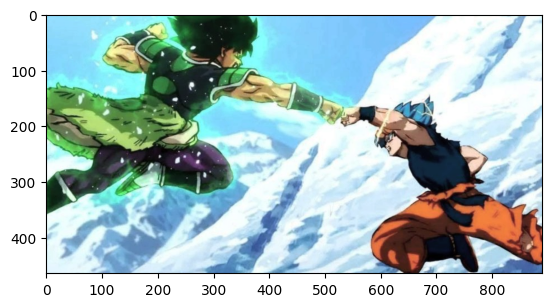

In [22]:
mods = {
    "angle_factor": 0,
    "sat_factor": 0.75
}

matrix_rgb_to_hsb = apply_rgb_to_hsb(img, mods)
matrix_hsb_to_rgb = apply_hsb_to_rgb(matrix_rgb_to_hsb)

plt.imshow(matrix_hsb_to_rgb)

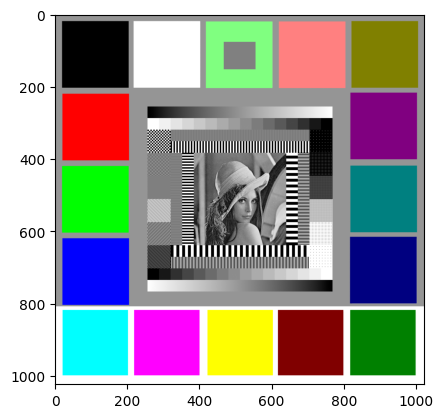

In [325]:
plt.imshow(img)

#### Modify R, G, B channels applying Negative effect (s = L-1-r)

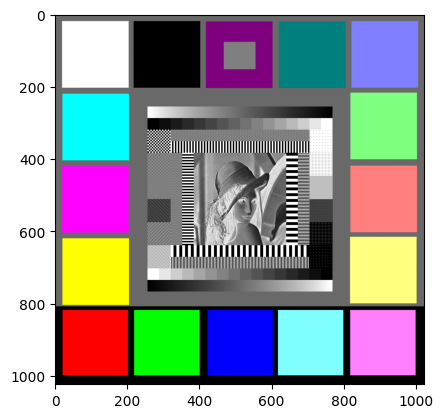

In [324]:
negative_img = apply_negative(img)
plt.imshow(negative_img)

### Correlação

In [189]:
def load_filter(filter_path):
    with open(filter_path, 'r') as file:
        line = file.readline()
        values = [float(x) for x in line.split()]
    
    m =  int(values[0])
    n = int(values[1])
    stride = int(values[2])

    filter = []
    for i in range(0, m):
        row = []
        for j in range(0, n):    
            row.append(values[3:][i*n + j])
        filter.append(row)
    
    return stride, np.array(filter)

"""
def correlation2D(matrix, filter, stride):
    nh = matrix.shape[0]
    nw = matrix.shape[1]
    sh = stride
    sw = stride
    kh = filter.shape[0]
    kw = filter.shape[1]

    max_w_it = int((nw - kw + sw) / sw)
    max_h_it = int((nh - kh + sh ) / sh)

    matrix_output = np.zeros((max_h_it, max_w_it))
    
    h = 0
    for i in range(0, max_h_it):
        w = 0
        for j in range(0, max_w_it):
            value = qml.math.frobenius_inner_product(matrix[h:h+kh, w:w+kw], filter)
            matrix_output[i,j] = round(value)
            w += sw
        h += sh
        
    return matrix_output.astype(int)
"""

def correlation2D(matrix, filter, stride):
    nh = matrix.shape[0]
    nw = matrix.shape[1]
    sh = stride
    sw = stride
    kh = filter.shape[0]
    kw = filter.shape[1]

    max_w_it = int((nw - kw + sw) / sw)
    max_h_it = int((nh - kh + sh ) / sh)

    print(max_h_it, max_w_it)
    print(max_h_it * sh,max_w_it * sw)

    def calculate_value(h, w):
        return round(np.sum(matrix[h:h+kh, w:w+kw] * filter))

    matrix_output = Parallel(n_jobs=-1)(delayed(calculate_value)(h, w)
                                         for h in range(0, max_h_it * sh, sh)
                                         for w in range(0, max_w_it * sw, sw))
    
    matrix_output = np.array(matrix_output).reshape(max_h_it, max_w_it).astype(int)
    
    return matrix_output

"""
def apply_correlation(matrix, filter, stride=1):
    if(stride > 1):
        return convolve2d(matrix, filter, mode='valid')[::stride, ::stride].astype(int)
    else:
        return convolve2d(matrix, filter, mode='valid').astype(int)
"""

def apply_transform_box(image_channels, stride, filter):
    # Record the start time
    start_time = time.time()

    R, G, B = image_channels
    
    R_box = correlation2D(R, filter, stride)
    G_box = correlation2D(G, filter, stride)
    B_box = correlation2D(B, filter, stride)

    img_merged_box = cv2.merge((R_box, G_box, B_box))

    # Record the end time
    end_time = time.time()
    
    return img_merged_box, end_time - start_time

def histogram_expansion(matrix):
    r_max = matrix.max()
    r_min = matrix.min()
    l = 255

    expansion = lambda r : round((r - r_min) * (l - 1) / (r_max - r_min))

    return np.vectorize(expansion)(matrix)


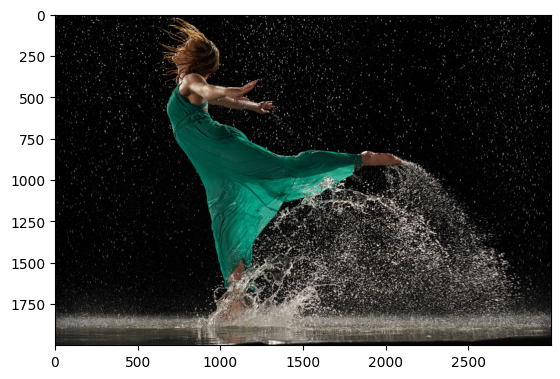

In [190]:
img = cv2.cvtColor(cv2.imread("DancingInWater.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img)

#### Filtro box 15x15

Execution time: 84470.802ms


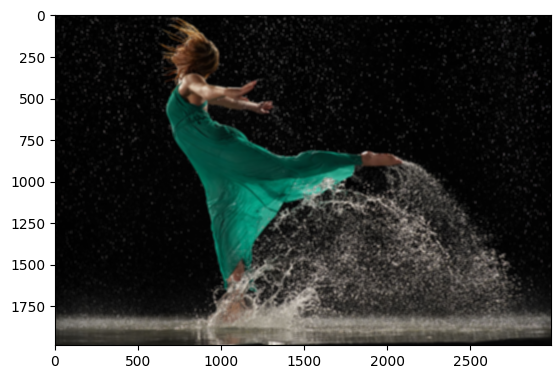

In [195]:
stride_15x15, filter_box_15x15 = load_filter("filtro_box_15x15.txt")
img_merged_box_15x15, exec_time_box_15x15 = apply_transform_box(cv2.split(img), stride_15x15, filter_box_15x15)
plt.imshow(img_merged_box_15x15)
print(f"Execution time: {round(exec_time_box_15x15*1000, 3)}ms")

#### Box filter 1x15 followed by box filter 15x1

Execution time: 163761.696ms


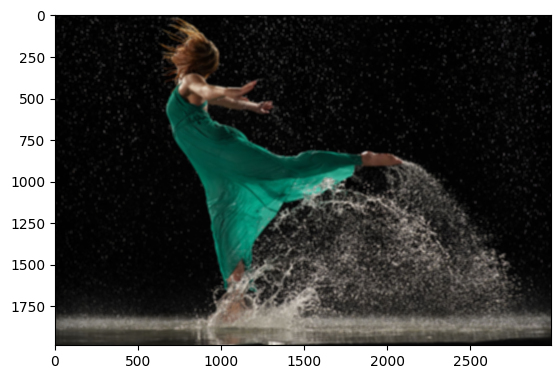

In [197]:
stride_1x15, filter_box_1x15 = load_filter("filtro_box_1x15.txt")

img_merged_box_1x15, exec_time_box_1x15 = apply_transform_box(cv2.split(img), stride_1x15, filter_box_1x15)

stride_15x1, filter_box_15x1 = load_filter("filtro_box_15x1.txt")
img_merged_box_15x1, exec_time_box_15x1 = apply_transform_box(cv2.split(img_merged_box_1x15), stride_15x1, filter_box_15x1)

print(f"Execution time: {round((exec_time_box_1x15 + exec_time_box_15x1)*1000, 3)}ms")
plt.imshow(img_merged_box_15x1)

In [198]:
img_merged_box_15x1.shape

(1986, 2986, 3)

### Filtro de Sobel

In [199]:
img = cv2.cvtColor(cv2.imread("lena.jpg"), cv2.COLOR_BGR2RGB)

In [200]:
R, G, B = cv2.split(img)

stride_horizontal, filtro_sobel_horizontal = load_filter("filtro_sobel_horizontal.txt")

R_sobel_horizontal = np.abs(correlation2D(R, filtro_sobel_horizontal, stride_horizontal))
G_sobel_horizontal = np.abs(correlation2D(G, filtro_sobel_horizontal, stride_horizontal))
B_sobel_horizontal = np.abs(correlation2D(B, filtro_sobel_horizontal, stride_horizontal))

stride_vertical, filtro_sobel_vertical = load_filter("filtro_sobel_vertical.txt")

R_sobel_vertical = np.abs(correlation2D(R, filtro_sobel_vertical, stride_vertical))
G_sobel_vertical = np.abs(correlation2D(G, filtro_sobel_vertical, stride_vertical))
B_sobel_vertical = np.abs(correlation2D(B, filtro_sobel_vertical, stride_vertical))


In [201]:
R_sobel = histogram_expansion(R_sobel_horizontal + R_sobel_vertical)
G_sobel = histogram_expansion(G_sobel_horizontal + G_sobel_vertical)
B_sobel = histogram_expansion(B_sobel_horizontal + B_sobel_vertical)

#### Sobel applied over R channel

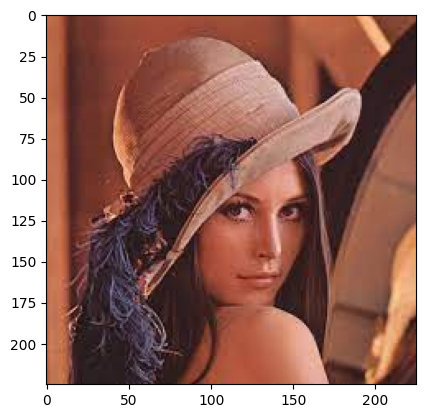

In [316]:
plt.imshow(img)

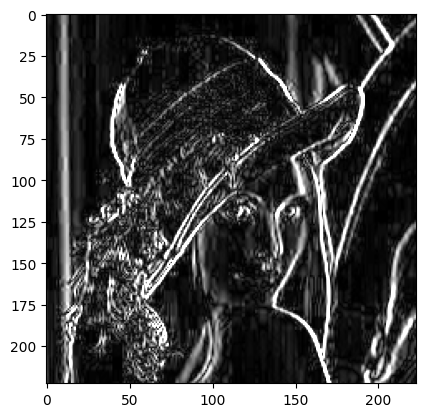

In [202]:
plt.imshow(R_sobel_vertical, cmap='gray', vmin=0, vmax=255)

#### Sobel applied over G channel

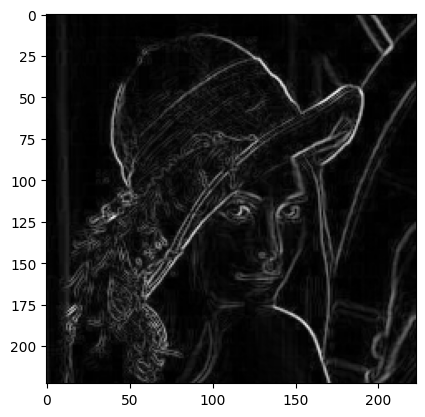

In [203]:
plt.imshow(G_sobel, cmap='gray', vmin=0, vmax=255)

#### Sobel applied over B channel

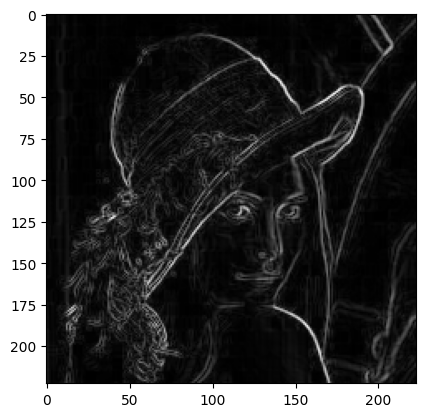

In [204]:
plt.imshow(B_sobel, cmap='gray', vmin=0, vmax=255)